In [26]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

In [27]:
train_ds, test_ds= tfds.load('mnist', split =['train', 'test'], as_supervised = True)

In [28]:
def prepare_dataset(mnist):
  mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
  mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
  mnist = mnist.map(lambda img, target: ((img/128)-1, target))
  mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth = 10)))

  mnist = mnist.cache()
  mnist = mnist.shuffle(1024)
  mnist = mnist.batch(64)
  mnist = mnist.prefetch(20)

  return mnist

In [29]:
train_ds = train_ds.apply(prepare_dataset)
test_ds = test_ds.apply(prepare_dataset)

In [30]:
#Model creation via Subclassing from tf.keras.Model
class MLP_Model(tf.keras.Model):
  def __init__(self, layer_sizes, output_size=10):
    super().__init__()
    self.mlp_layers = []
    #layer_sizes e.g. [256, 256]
    for layer_size in layer_sizes:
      new_layer = tf.keras.layers.Dense(units=layer_size, activation='sigmoid')
      self.mlp_layers.append(new_layer)
    self.output_layer = tf.keras.layers.Dense(units=output_size, activation='softmax')

  def call(self, x):
    for layer in self.mlp_layers:
      x = layer(x)
    y = self.output_layer(x)
    return y

In [31]:
def training_loop(nr_epochs, model, training_set, test_ds, loss_func, optimizer, train_loss, train_acc, test_loss, test_acc,):

  for epoch in range(nr_epochs):
    training_losses_agg = []
    test_loss_agg = []
    test_acc_agg = []
    train_acc_agg = []
    for (x, y) in training_set:
      with tf.GradientTape() as tape:
        prediction = model(x)
        loss = loss_func(y, prediction)
      gradients = tape.gradient(loss, model.variables)
      optimizer.apply_gradients(zip(gradients, model.variables))
      train_acc_sample = np.argmax(y, axis = 1) == np.argmax(prediction, axis = 1)
      train_acc_agg.append(np.mean(train_acc_sample)) #mean bc of batch
      training_losses_agg.append(loss.numpy())

    for (x, y) in test_ds:
      pred = model(x)
      test_loss_sample = loss_func(y, pred)
      test_acc_sample = np.argmax(y, axis = 1) == np.argmax(pred, axis = 1)
      test_loss_agg.append(test_loss_sample.numpy())
      test_acc_agg.append(np.mean(test_acc_sample)) #mean bc of batch

    train_loss[epoch] = np.mean(training_losses_agg)
    train_acc[epoch] = np.mean(train_acc_agg)
    test_loss[epoch] = np.mean(test_loss_agg)
    test_acc[epoch] = np.mean(test_acc_agg)

  return train_loss, train_acc, test_loss, test_acc

In [32]:
def test_acc(model, test_ds, loss_func):
  test_loss_agg = []
  test_acc_agg = []
  for (x, y) in test_ds:
    pred = model(x)
    test_loss_sample = loss_func(y, pred)
    test_acc_sample = np.argmax(y, axis = 1) == np.argmax(pred, axis = 1)
    test_loss_agg.append(test_loss_sample.numpy())
    test_acc_agg.append(np.mean(test_acc_sample)) #mean bc of batch

  test_loss = tf.reduce_mean(test_loss_agg)
  test_acc = tf.reduce_mean(test_acc_agg)
  return test_loss, test_acc

In [33]:
my_network = MLP_Model([784,256], 10)
learning_rate = 0.05
epochs = 6
cce = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate)
train_loss = np.zeros(epochs)
test_loss = np.zeros(epochs)
test_acc = np.zeros(epochs)
train_acc = np.zeros(epochs)

train_loss, train_acc, test_loss, test_acc = training_loop(epochs, my_network, train_ds, test_ds, cce, optimizer, train_loss, test_acc, test_loss, test_acc)

In [37]:
print(test_acc)

[0.88017516 0.90047771 0.91052946 0.91301752 0.91669984 0.92177548]


In [35]:
def visualization (train_losses ,train_accuracies, test_losses , test_accuracies):
    fig = plt.figure()
    training_steps = np.arange(train_losses.shape[0])
    line1, = plt.plot(training_steps, train_losses , "b-")
    line2, = plt.plot(training_steps, test_losses , "r-")
    line3, = plt.plot (training_steps, train_accuracies , "b:")
    line4, = plt.plot(training_steps, test_accuracies , "r:")
    plt.xlabel(" Training steps ")
    plt.ylabel(" Loss / Accuracy ")
    plt.legend((line1 , line2, line3 , line4 ) , (" training loss ", "test loss", "train accuracies", " test accuracies "))
    plt.show()

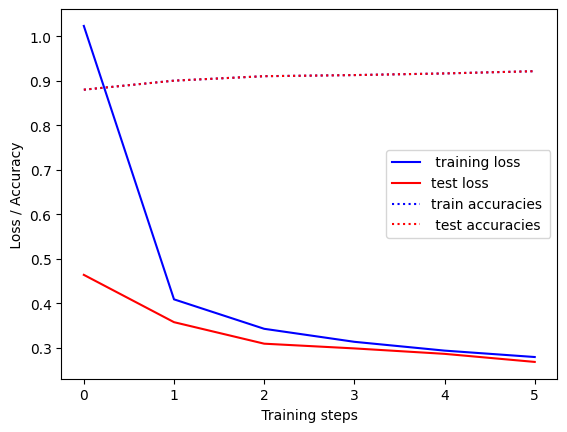

In [36]:
visualization(train_loss, train_acc, test_loss, test_acc)

Observations:
1. Model performs even better when one layer is taken away so only one hidden layer of 256. The test acc is already significant high after 3 epochs.

2.A learning rate of 0.1 seems also to work with the same but faster result

3.A learning rate of 1 seems to still work which is surprising. I would have imagined the model to miss the optimal weights.

4. A Batch of 64 instead of 32 and a learning rate of 0.05 again results in a smaller test accuracy (0.92 vs 0.96 before), but computes much faster.